# NLP Project

## Imports

Data Handling

In [1]:
import pandas as pd
import numpy as np
import random
import time
random.seed(0)

sklearn stuff

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay



## Dataset Loading

Mount Drive For Faster Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Folder Path

In [4]:
project_folder = '/content/drive/MyDrive/NLP_Group_Project'

Load the files into a dataframe

In [5]:
csv_file = f'{project_folder}/yelp_reviews_clean_merged_ml_ready.csv'
df = pd.read_csv(csv_file)


In [6]:
# change to standard 0 and 1
df['label'] = df['label'].replace({1: 0, 2: 1})

Display a few items

In [7]:
display_list = []
for n in range(20):
  display_list.append(random.randint(0,df.shape[0]-1))
df_disp = df.iloc[display_list]
display(df_disp)

,label,clean_text
403958,1,great selection of import craft beers if you a...
441001,1,we live in the area and were looking for a new...
42450,0,why so smoky its like cheech and fucking chong...
271493,1,been coming to this dolce for the past three y...
536110,1,really pretty good coffee and the choices of p...
509532,1,if youre looking for a hip and fun place to st...
424604,1,awesome crab cakes and the one of the best sca...
318046,1,stayed here on frisat for a girls bday weekend...
499748,0,very disappointedcalamari was salty cesar sala...
375441,1,ive lived here for years now and although it h...


## Train Test Splits & Vectorizations

In [8]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


If we already ran these...

In [10]:
"""
from scipy.sparse import load_npz

X_train_count = load_npz("X_train_count.npz")
X_test_count = load_npz("X_test_count.npz")

X_train_tfidf = load_npz("X_train_tfidf.npz")
X_test_tfidf = load_npz("X_test_tfidf.npz")

X_train_tfidf_bigram = load_npz("X_train_tfidf_bigram.npz")
X_test_tfidf_bigram = load_npz("X_test_tfidf_bigram.npz")

y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
"""

'\nfrom scipy.sparse import load_npz\n\nX_train_count = load_npz("X_train_count.npz")\nX_test_count = load_npz("X_test_count.npz")\n\nX_train_tfidf = load_npz("X_train_tfidf.npz")\nX_test_tfidf = load_npz("X_test_tfidf.npz")\n\nX_train_tfidf_bigram = load_npz("X_train_tfidf_bigram.npz")\nX_test_tfidf_bigram = load_npz("X_test_tfidf_bigram.npz")\n\ny_train = np.load("y_train.npy")\ny_test = np.load("y_test.npy")\n'

Some Paramaters for later

In [11]:
num_feat = 2000

Basic Approach with standard word count vectors (just raw counts)

In [12]:
count_vector = CountVectorizer(stop_words='english', max_features=num_feat)

X_train_count = count_vector.fit_transform(X_train)
X_test_count = count_vector.transform(X_test)

TF-IDF Approach  (Gives common words less weight, rare more)

In [13]:
tfidf_vector = TfidfVectorizer(stop_words='english', max_features = num_feat)
X_train_tfidf = tfidf_vector.fit_transform(X_train)
X_test_tfidf = tfidf_vector.transform(X_test)

TF-IDF With Bigrams

In [14]:
tfidf_bigram_vector = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = num_feat)
X_train_tfidf_bigram = tfidf_bigram_vector.fit_transform(X_train)
X_test_tfidf_bigram = tfidf_bigram_vector.transform(X_test)

These are Slow, save for later

In [15]:
from scipy.sparse import save_npz
import numpy as np

# Count Vectors
save_npz("X_train_count.npz", X_train_count)
save_npz("X_test_count.npz", X_test_count)

# TF-IDF Vectors
save_npz("X_train_tfidf.npz", X_train_tfidf)
save_npz("X_test_tfidf.npz", X_test_tfidf)

# TF-IDF Bigrams
save_npz("X_train_tfidf_bigram.npz", X_train_tfidf_bigram)
save_npz("X_test_tfidf_bigram.npz", X_test_tfidf_bigram)

#Labels
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print("All vectorized datasets and labels saved successfully!")


All vectorized datasets and labels saved successfully!


## Wrapper Functions

In [16]:
def get_metrics(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred, average='weighted')
  rec = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')
  # group up all this
  metrics_df = pd.DataFrame(
      {'Accuracy': [acc],
       'Precision': [prec],
       'Recall': [rec],
       'F1 Score': [f1]}
      )
  matrix = confusion_matrix(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  # classification report
  print(report)

  return metrics_df, matrix


In [17]:
def get_visuals(model, matrix, X, y):

  # confusion matrix
  cm_disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
  cm_disp.plot(cmap='Blues')
  # ROC AUC
  roc_acu = RocCurveDisplay.from_estimator(model, X, y)

In [18]:
def naive_bayes_model(X_train, y_train, X_test, y_test):
  clf = MultinomialNB()
  start_time = time.time()
  clf.fit(X_train, y_train)
  train_time = time.time() - start_time
  y_pred = clf.predict(X_test)
  return clf, y_pred, train_time

In [19]:
def run_mlp(X_train, y_train, X_test, y_test):
  model = MLPClassifier(hidden_layer_sizes=(100,),
                        activation='relu',
                        solver='adam',
                        batch_size='auto',
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        early_stopping=True,
                        max_iter=20,
                        random_state=0)
  start_time = time.time()
  model.fit(X_train, y_train)
  train_time = time.time() - start_time
  y_pred = model.predict(X_test)
  return model, y_pred, train_time

## Naive Bayes Classification

### Count Vector Version

In [20]:
clf_count, y_pred_count, nb_count_time = naive_bayes_model(X_train_count, y_train, X_test_count, y_test)
df_cv_metrics, cv_matrix = get_metrics(y_test, y_pred_count)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     59617
           1       0.83      0.88      0.86     59826

    accuracy                           0.85    119443
   macro avg       0.86      0.85      0.85    119443
weighted avg       0.86      0.85      0.85    119443



Visuals

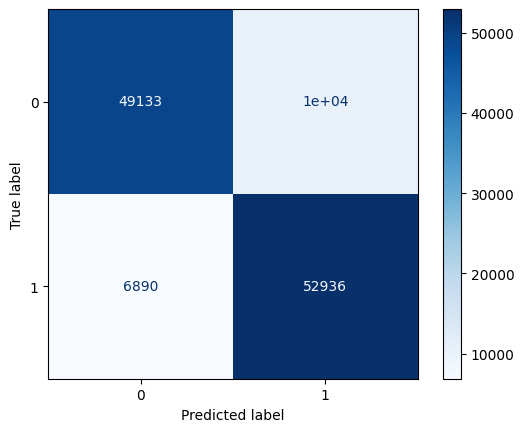

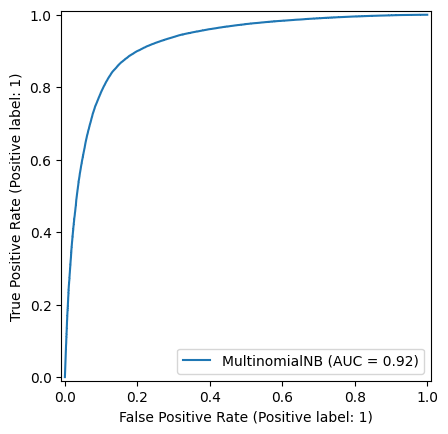

In [21]:
get_visuals(clf_count, cv_matrix, X_test_count, y_test)

### TF-IDF Version

Model and Get Metrics

In [22]:
clf_tfidf, y_pred_tfidf,nb_tfidf_time = naive_bayes_model(X_train_tfidf, y_train, X_test_tfidf, y_test)
df_tfidf_metrics, tfidf_matrix = get_metrics(y_test, y_pred_tfidf)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     59617
           1       0.86      0.87      0.87     59826

    accuracy                           0.86    119443
   macro avg       0.86      0.86      0.86    119443
weighted avg       0.86      0.86      0.86    119443



Print out Useful Visuals

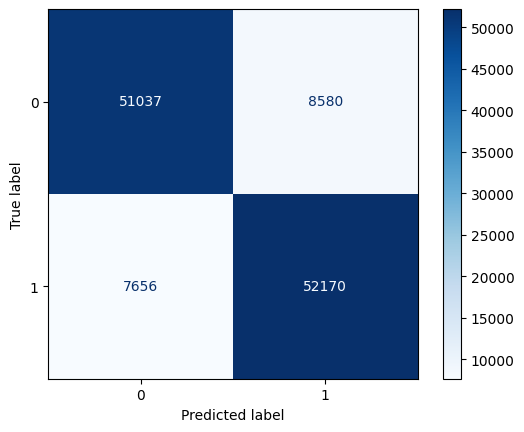

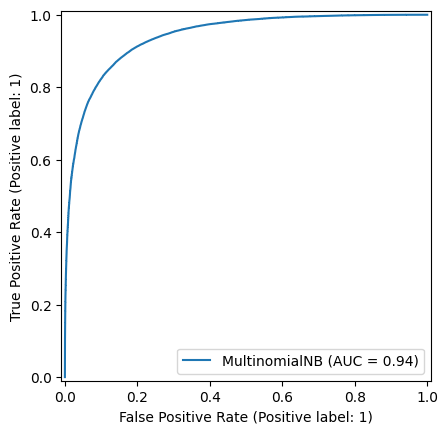

In [23]:
get_visuals(clf_tfidf, tfidf_matrix, X_test_tfidf, y_test)

### TF-IDF BiGrams

In [24]:
clf_bigram, y_pred_bigram, nb_bigram_time = naive_bayes_model(X_train_tfidf_bigram, y_train, X_test_tfidf_bigram, y_test)
df_bigram_metrics, bigram_matrix = get_metrics(y_test, y_pred_bigram)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     59617
           1       0.86      0.87      0.87     59826

    accuracy                           0.87    119443
   macro avg       0.87      0.87      0.87    119443
weighted avg       0.87      0.87      0.87    119443



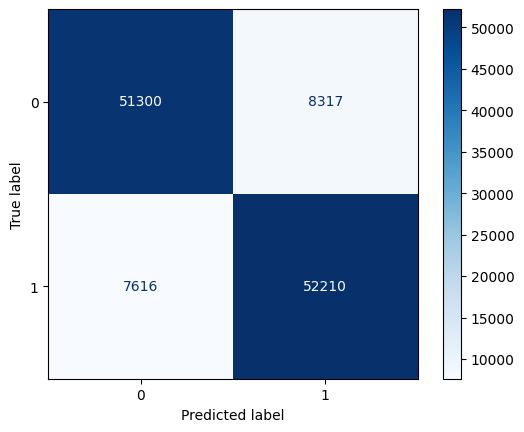

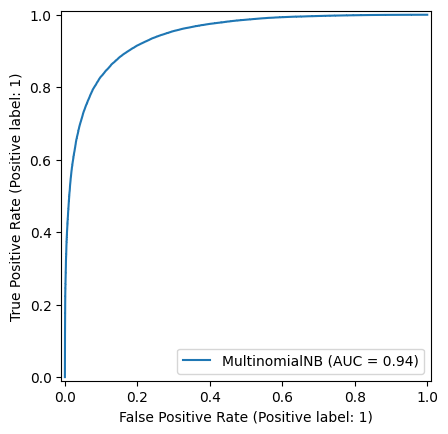

In [25]:
get_visuals(clf_bigram, bigram_matrix, X_test_tfidf_bigram, y_test)

## MLP Model

### count vector mlp

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     59617
           1       0.92      0.91      0.91     59826

    accuracy                           0.91    119443
   macro avg       0.91      0.91      0.91    119443
weighted avg       0.91      0.91      0.91    119443



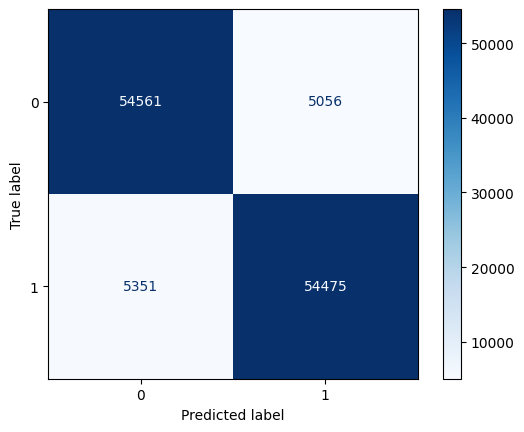

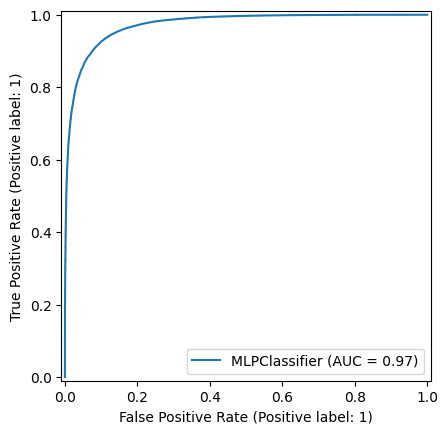

In [26]:
# try this, then keras...not sure what's better
mlp_count_vector, y_mlp_pred_count, mlp_count_time = run_mlp(X_train_count,y_train, X_test_count, y_test)
df_mlp_cv_metrics, mlp_cv_matrix = get_metrics(y_test, y_mlp_pred_count)
get_visuals(mlp_count_vector, mlp_cv_matrix, X_test_count, y_test)


In [27]:
from joblib import dump, load

# Save the trained MLP
dump(mlp_count_vector, "mlp_count_vector.joblib")

['mlp_count_vector.joblib']

### Tfidf mlp

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     59617
           1       0.92      0.91      0.92     59826

    accuracy                           0.91    119443
   macro avg       0.91      0.91      0.91    119443
weighted avg       0.91      0.91      0.91    119443



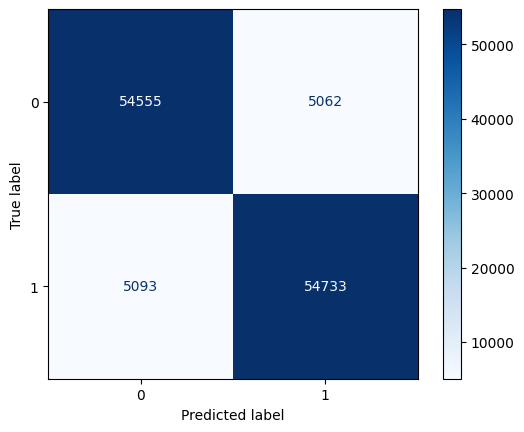

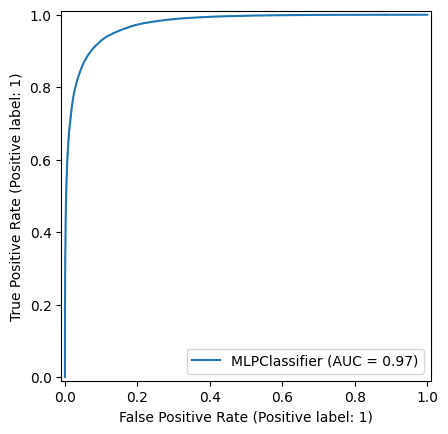

In [28]:
mlp_tfidf, y_mlp_pred_tfidf,mlp_tfidf_time = run_mlp(X_train_tfidf,y_train, X_test_tfidf, y_test)
df_mlp_tfidf,mlp_tfidf_matrix = get_metrics(y_test,y_mlp_pred_tfidf)
get_visuals(mlp_tfidf, mlp_tfidf_matrix, X_test_tfidf, y_test)

In [29]:
dump(mlp_tfidf, "mlp_tfidf.joblib")

['mlp_tfidf.joblib']

### Bigrams

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     59617
           1       0.91      0.91      0.91     59826

    accuracy                           0.91    119443
   macro avg       0.91      0.91      0.91    119443
weighted avg       0.91      0.91      0.91    119443



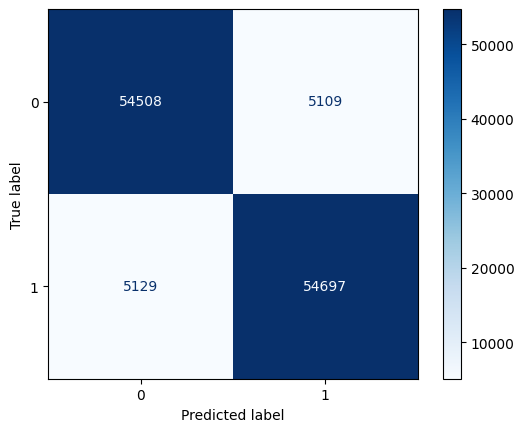

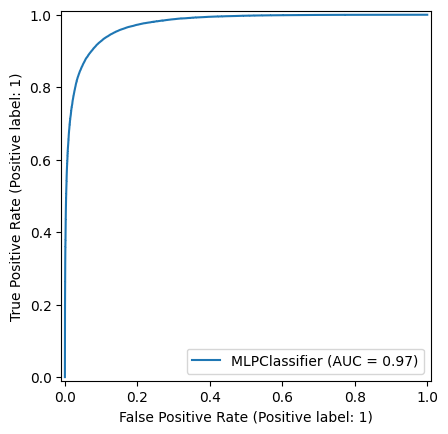

In [30]:
mlp_bigrams, y_mlp_bigrams, mlp_bigrams_time = run_mlp(X_train_tfidf_bigram,y_train, X_test_tfidf_bigram, y_test)
df_mlp_bigrams,mlp_bigrams_matrix = get_metrics(y_test, y_mlp_bigrams)
get_visuals(mlp_bigrams, mlp_bigrams_matrix, X_test_tfidf_bigram, y_test)

In [31]:
dump(mlp_bigrams, "mlp_bigrams.joblib")

['mlp_bigrams.joblib']

## Metrics

### metrics compare

In [34]:
# forgot this earlier, i'll fix it later - JL 2/9 6:35pm
from sklearn.metrics import roc_auc_score

# Compute AUC for each model
df_cv_metrics['AUC'] = roc_auc_score(y_test, clf_count.predict_proba(X_test_count)[:,1])
df_tfidf_metrics['AUC'] = roc_auc_score(y_test, clf_tfidf.predict_proba(X_test_tfidf)[:,1])
df_bigram_metrics['AUC'] = roc_auc_score(y_test, clf_bigram.predict_proba(X_test_tfidf_bigram)[:,1])

df_mlp_cv_metrics['AUC'] = roc_auc_score(y_test, mlp_count_vector.predict_proba(X_test_count)[:,1])
df_mlp_tfidf['AUC'] = roc_auc_score(y_test, mlp_tfidf.predict_proba(X_test_tfidf)[:,1])
df_mlp_bigrams['AUC'] = roc_auc_score(y_test, mlp_bigrams.predict_proba(X_test_tfidf_bigram)[:,1])

df_cv_metrics['Training Time'] = nb_count_time
df_tfidf_metrics['Training Time'] = nb_tfidf_time
df_bigram_metrics['Training Time'] = nb_bigram_time

df_mlp_cv_metrics['Training Time'] = mlp_count_time
df_mlp_tfidf['Training Time'] = mlp_tfidf_time
df_mlp_bigrams['Training Time'] = mlp_bigrams_time
# Add model labels
df_cv_metrics['Model'] = 'NB Count'
df_tfidf_metrics['Model'] = 'NB TF-IDF'
df_bigram_metrics['Model'] = 'NB TF-IDF Bigram'
df_mlp_cv_metrics['Model'] = 'MLP Count'
df_mlp_tfidf['Model'] = 'MLP TF-IDF'
df_mlp_bigrams['Model'] = 'MLP TF-IDF Bigram'

# Combine all into one DataFrame
df_all_metrics = pd.concat([
    df_cv_metrics,
    df_tfidf_metrics,
    df_bigram_metrics,
    df_mlp_cv_metrics,
    df_mlp_tfidf,
    df_mlp_bigrams
], ignore_index=True)

# Reorder nicely
df_all_metrics = df_all_metrics[['Model', 'Training Time','Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']]

# Export to CSV
df_all_metrics.to_csv("/content/drive/MyDrive/NLP_Group_Project/yelp_sentiment_model_comparison.csv", index=False)

display(df_all_metrics)

,Model,Training Time,Accuracy,Precision,Recall,F1 Score,AUC
0,NB Count,0.208734,0.854541,0.855815,0.854541,0.854402,0.920373
1,NB TF-IDF,0.241601,0.864069,0.864153,0.864069,0.864059,0.940356
2,NB TF-IDF Bigram,0.239421,0.866606,0.866654,0.866606,0.866600,0.942524
3,MLP Count,200.948519,0.912871,0.912881,0.912871,0.912870,0.972871
4,MLP TF-IDF,295.929676,0.914980,0.914981,0.914980,0.914980,0.973851
5,MLP TF-IDF Bigram,252.199576,0.914285,0.914286,0.914285,0.914285,0.973870


### loss curves

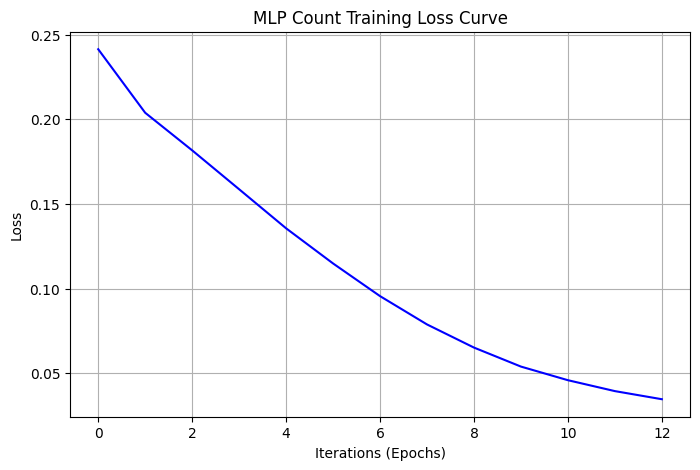

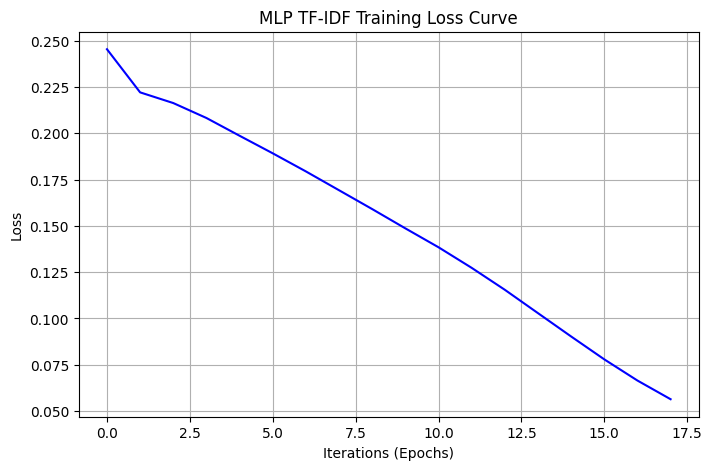

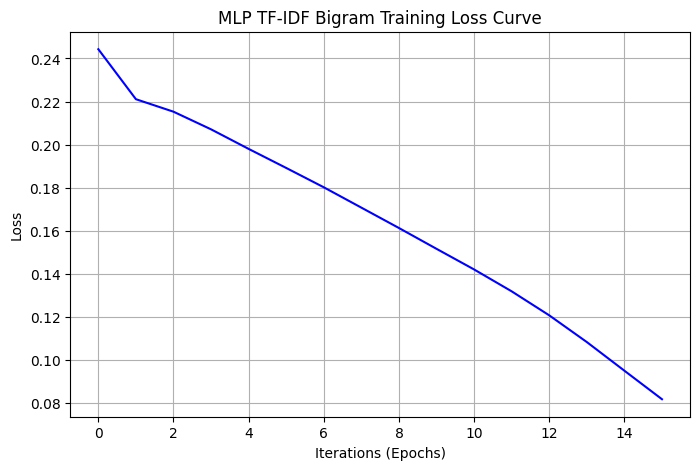

In [35]:
import matplotlib.pyplot as plt

mlp_models = {
    "MLP Count": mlp_count_vector.loss_curve_,
    "MLP TF-IDF": mlp_tfidf.loss_curve_,
    "MLP TF-IDF Bigram": mlp_bigrams.loss_curve_
}

for name, loss_curve in mlp_models.items():
    plt.figure(figsize=(8,5))
    plt.plot(loss_curve, color='blue')
    plt.title(f'{name} Training Loss Curve')
    plt.xlabel('Iterations (Epochs)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


### comparison of metrics

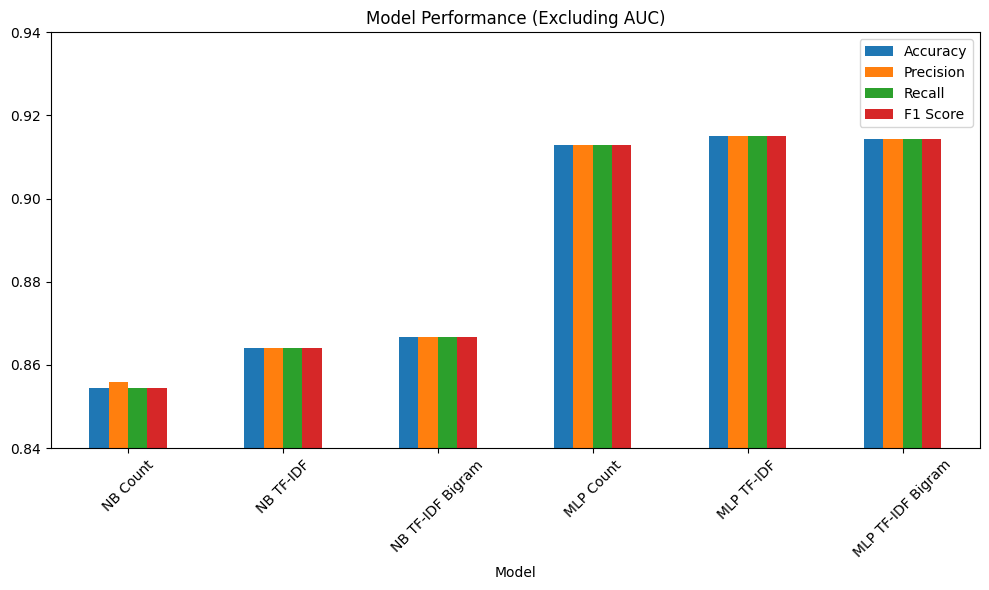

In [37]:
# Drop Training Time and AUC (so high it's ruiing scale) and plot
df_all_metrics.drop(columns=['AUC','Training Time']).set_index('Model').plot(kind='bar', figsize=(10, 6))

plt.ylim(0.84, 0.94)
plt.title('Model Performance (Excluding AUC)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('comparison_no_auc.png')

Export Everything Useful

In [39]:
from google.colab import files

# Zip everything worth keeping
!zip -r final_submission.zip /content/*.png /content/*.npz /content/*.joblib

# Download it to your computer
files.download('final_submission.zip')

updating: content/comparison_no_auc.png (deflated 20%)
updating: content/metrics_bars.png (deflated 34%)
updating: content/pandas_grouped_chart.png (deflated 20%)
  adding: content/X_test_count.npz (deflated 1%)
  adding: content/X_test_tfidf_bigram.npz (deflated 0%)
  adding: content/X_test_tfidf.npz (deflated 0%)
  adding: content/X_train_count.npz (deflated 1%)
  adding: content/X_train_tfidf_bigram.npz (deflated 0%)
  adding: content/X_train_tfidf.npz (deflated 0%)
  adding: content/mlp_bigrams.joblib (deflated 4%)
  adding: content/mlp_count_vector.joblib (deflated 4%)
  adding: content/mlp_tfidf.joblib (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>